In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tsdata1.xlsx to tsdata1.xlsx


In [ ]:
italy = pd.read_excel('tsdata1.xlsx', index_col='Date', parse_dates=True)
italy.head()

,IT,EXOG1,EXOG2
Date,,,
2013-10-01,151.996076,17.54,11.20
2013-10-02,148.865675,17.39,11.07
2013-10-03,155.963230,16.16,12.73
2013-10-04,164.411660,16.22,10.53
2013-10-05,131.043380,16.04,10.88


EXOG1 - температура воздуха;
EXOG2 - скорость ветра

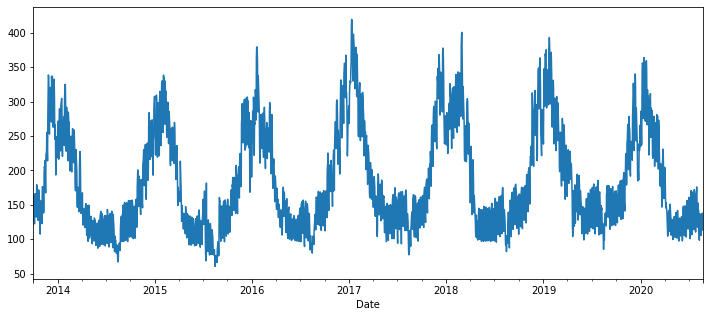

In [ ]:
italy['IT'].plot(figsize=(12,5))
plt.show()

#1. Прогнозирование моделью SARIMAX

In [ ]:
p = range(0, 3)
q = range(0, 3)
P = range(0, 2)
Q = range(0, 2)

In [ ]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
italy.index.freq = 'D'

results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(italy['IT'],
                        order=(params[0], 1, params[1]), 
                        seasonal_order=(params[2], 1, params[3], 12),
                        exog=italy[['EXOG1', 'EXOG2']]).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters           aic
35  (2, 2, 1, 1)  21810.310725
31  (2, 1, 1, 1)  22384.795420
23  (1, 2, 1, 1)  22484.634855
11  (0, 2, 1, 1)  22509.261742
33  (2, 2, 0, 1)  22532.600946


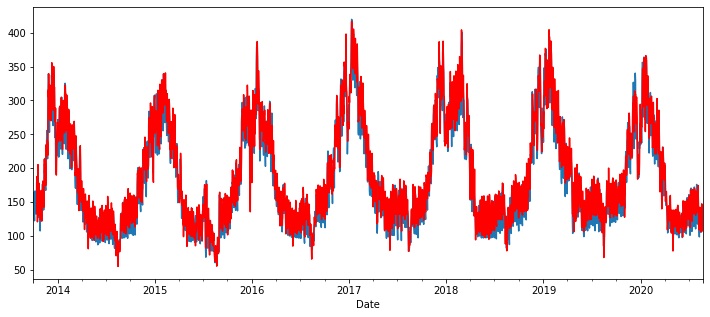

In [10]:
italy['model'] = best_model.fittedvalues
italy['IT'].plot(figsize=(12,5))
italy.model[13:].plot(color='r')
plt.show()

#2. Прогнозирование моделью Prophet

In [20]:
data_prophet = italy[['IT', 'EXOG1', 'EXOG2']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y', 'EXOG1', 'EXOG2']
data_prophet.head()

,ds,y,EXOG1,EXOG2
0,2013-10-01,151.996076,17.54,11.20
1,2013-10-02,148.865675,17.39,11.07
2,2013-10-03,155.963230,16.16,12.73
3,2013-10-04,164.411660,16.22,10.53
4,2013-10-05,131.043380,16.04,10.88


In [23]:
model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=True)
model.add_seasonality(name='months', period=30, fourier_order=5)
model.add_regressor('EXOG1')
model.add_regressor('EXOG2')
model.fit(data_prophet)

In [24]:
future = model.make_future_dataframe(periods=0, freq='D')
future['EXOG1'] = italy['EXOG1'].values
future['EXOG2'] = italy['EXOG2'].values

In [25]:
forecast = model.predict(future)

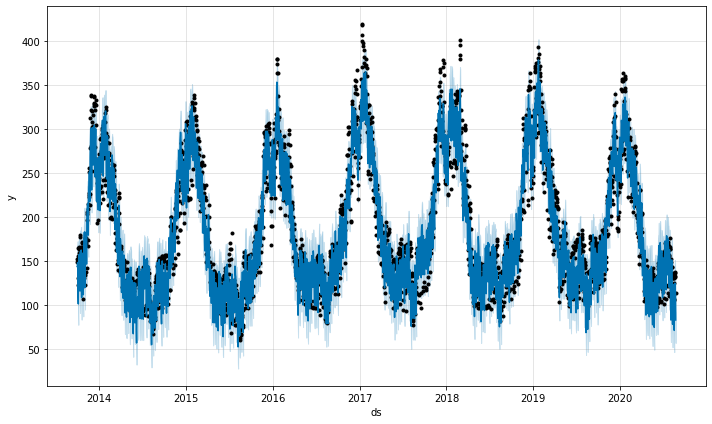

In [26]:
model.plot(forecast)
plt.show()

#3. Сравнение полученных предсказаний с помощью MSE

In [31]:
MSE_prophet = mean_squared_error(italy['IT'].values, forecast['yhat'].values)
MSE_SARIMAX = mean_squared_error(italy['IT'].values, italy['model'].values)

In [32]:
print('MSE_prophet: {} \nMSE_SARIMAX: {}'.format(MSE_prophet, MSE_SARIMAX))

MSE_prophet: 375.2813471883554 
MSE_SARIMAX: 370.08090859684125


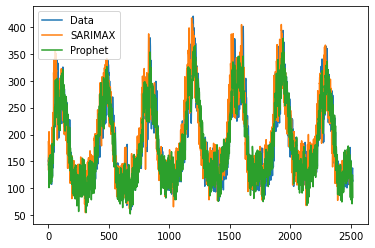

In [33]:
plt.plot(italy['IT'].values, label='Data')
plt.plot(italy['model'][13:].values, label='SARIMAX')
plt.plot(forecast['yhat'].values, label='Prophet')
plt.legend()
plt.show()